# Going Deeper 05 Sentiment Analysis of NSMC
###### 온라인 코어 2기 박수경  

이번 과제에서는 네이버 영화의 댓글을 모아놓은 데이터셋인 NSMC, Naver sentiment movie corpus v1.0 (https://github.com/e9t/nsmc) 에서 작성자의 평가를 긍정적(1),부정적(0)으로 나누는 sentiment analyzer를 모델링 해 본다.  
텍스트 분석은 다양한 사람들의 텍스트에서 직접적인 반응을 수집할 수 있어서 실시간 트렌드를 빠르게 알 수 있다는 강점이 있다.  
분석에 대한 접근법은 크게 머신러닝 기반 접근법과 sentiment dictionary를 기반으로 한 접근법이 있다.  

이번에는 word embedding기법을 사용해 텍스트를 단어별로 저차원의 벡터로 변환하여 인공지능 모델을 학습시킨다.  

In [1]:
#사용할 라이브러리 import

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.initializers import Constant #스칼라 상수값으로 웨이트 초기값 설정

import os
import matplotlib.pyplot as plt

import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

import konlpy
from konlpy.tag import Mecab

from collections import Counter

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


레이블이 잘 맞지 않는 경우도 찾을 수 있었다. (너무재미있어서 보는 것을 추천한다는 리뷰가 '부정적'으로 레이블링되는 등)

## 1) load_data() 만들기

데이터를 읽어오고 난 후에는 데이터로더를 구성한다. 데이터로더는 가공되지 않은 텍스트를 적절히 정제하여 형태소 기반의 한국어 토큰으로 바꾸고, stopwords를 제거하여 사전 word_to_index를 만든다. 데이터로더는 X_train, y_train, X_test, y_test, word_to_index를 리턴하게 작성한다.  

stopwords(불용어)란, 분석을 하는데 특별히 필요없는 단어들, 문법적인 요소로서 자주 등장하지만 분석대상일 필요가 없는 단어들을 의미한다. 
적당한 stopwords를 설정하여 리스트를 만들어두고 제거한다. (ref.1)

In [3]:

# pip install konlpy


In [4]:
# from konlpy.tag import Kkma #메모리부족
# tokenizer=Kkma()  

In [5]:
tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',\
#              '만약', '등','등등', '그래서', '네', '우선', '예', '에서', '통해', '왜', '해요', '했어요',\
#             '어떻게', '어떤', '어느', '어디', '대해', '말하자면', '그렇게', '말하면', '외에도','할','각',\
#             '각각', '음', '어떤', '게', '였','↑','as','습디다','네영','다','영화','고','을','보','었','해','합니다'] # 더 늘려보기

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=16000): #num_words 늘려보기
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
X_train[:4]
# y_train
# X_test
# y_test

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391],
 [24, 205, 3],
 [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]]

collections, counter의 most_common 메서드를 이용하는 방법은 다음과 같다. (ref.2)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()} #키와 밸류 바꾸기

In [8]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index) #전부 출력
print(word_to_index['완전'])
print(word_to_index['최고'])
print(word_to_index['별로'])

{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '서': 1

단어가 인코딩된 것을 확인할 수 있다.

## 2) encoding, decoding 작업 관련 함수 만들기

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공  
데이터셋 내 문장 길이 분포  
적절한 최대 문장 길이 지정  
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  

문장 길이의 분포는 다음과 같다.

In [10]:
len_list = []
for i in range(len(X_train)):
    len_list.append(len(X_train[i]))

len_list[:5]

[10, 17, 3, 13, 23]

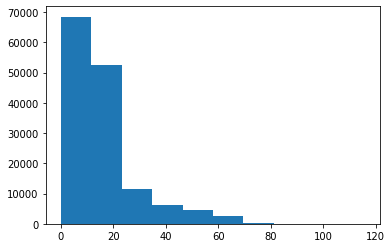

In [11]:

plt.hist(len_list)
plt.show()



가장 긴 문장은 몇개의 word로 이루어져있는지를 알아본다.

In [12]:
len_list.sort(reverse=True)
len_list[:10]

[116, 115, 106, 93, 88, 88, 86, 85, 84, 83]

우리가 가진 데이터에서 가장 긴 문장의 길이는 116이다. 모델에서 분석하는 문장의 최대길이 maxlen을 설정할 수 있다. 나는 먼저, 길이에 제한을 두지 않고 학습을 시켜보았다. 영화리뷰를 작성하는 칸 자체가 일정한 글자수 이내로 되어있기 때문이며, 리뷰의 서두나 말미(혹은 그 중간) 어느쪽에 핵심적 평가를 쓰느냐도 사람에 따라 다르기 때문이다.  
그러나 길이가 116인 문장은 1개일 뿐이고 대부분의 리뷰는 70 이하의 길이를 가지고 있다. maxlen을 116으로 설정할 경우 아주 많은 문장들이 지나치게 많은 패딩을 가지게 된다. 패딩 그 자체는 학습을 유의미하게 하는 데이터가 아니다.  

그래서 대부분의 문장이 속한 60길이 내의 범위만 학습하도록 한다.

In [13]:
vocab_size = len(word_to_index)  
word_vector_dim = 200  
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=60)
X_train.shape

(146182, 60)

In [14]:
output = embedding(X_train)
print(output[0])

tf.Tensor(
[[ 0.02067951 -0.04231187  0.02113215 ... -0.02672908 -0.0130386
  -0.02732642]
 [ 0.02067951 -0.04231187  0.02113215 ... -0.02672908 -0.0130386
  -0.02732642]
 [ 0.02067951 -0.04231187  0.02113215 ... -0.02672908 -0.0130386
  -0.02732642]
 ...
 [ 0.03295985  0.01624495 -0.00511055 ...  0.04807985  0.01719182
   0.0002364 ]
 [ 0.00933539  0.00025155 -0.03315949 ...  0.02203716  0.02669802
   0.02623328]
 [-0.03171618 -0.02426506 -0.00689908 ...  0.01430896  0.01692286
  -0.00890122]], shape=(60, 200), dtype=float32)


In [15]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=60)

X_test

array([[   0,    0,    0, ...,    0,  832,  130],
       [   0,    0,    0, ...,    0,    0,    3],
       [   0,    0,    0, ..., 3557,   73,  917],
       ...,
       [   0,    0,    0, ...,    8,   12, 3424],
       [   0,    0,    0, ...,   67,  323,   43],
       [   0,    0,    0, ...,  179,   63, 1058]], dtype=int32)

## 4) 모델 구성 및 validation set 구성  
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.  

In [16]:
vocab_size = 16000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(0.5))    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         3200000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,229,857
Trainable params: 3,229,857
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(256, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(0.5))    
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         3200000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         358656    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,757,857
Trainable params: 3,757,857
Non-trainable params: 0
____________________________________________

In [18]:

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(32, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         3200000   
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,206,465
Trainable params: 3,206,465
Non-trainable params: 0
_________________________________________________________________


In [19]:
## validation set 분리

# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182개
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 60)
(116182,)


## 5) 모델 훈련과 accuracy, val_loss 시각화

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= 'rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/30
114/114 - 5s - loss: 4.2135 - accuracy: 0.5845 - val_loss: 0.5794 - val_accuracy: 0.6584
Epoch 2/30
114/114 - 1s - loss: 4.0663 - accuracy: 0.6655 - val_loss: 0.5737 - val_accuracy: 0.6645
Epoch 3/30
114/114 - 1s - loss: 4.0389 - accuracy: 0.6740 - val_loss: 0.6524 - val_accuracy: 0.6090
Epoch 4/30
114/114 - 1s - loss: 4.0282 - accuracy: 0.6791 - val_loss: 0.5451 - val_accuracy: 0.6968
Epoch 5/30
114/114 - 1s - loss: 4.0478 - accuracy: 0.6805 - val_loss: 0.5661 - val_accuracy: 0.6854
Epoch 6/30
114/114 - 1s - loss: 3.9830 - accuracy: 0.6860 - val_loss: 0.5470 - val_accuracy: 0.6794
Epoch 7/30
114/114 - 1s - loss: 4.0348 - accuracy: 0.6858 - val_loss: 0.5598 - val_accuracy: 0.6632
Epoch 8/30
114/114 - 1s - loss: 4.0084 - accuracy: 0.6885 - val_loss: 0.5614 - val_accuracy: 0.6621
Epoch 9/30
114/114 - 1s - loss: 4.0060 - accuracy: 0.6906 - val_loss: 0.5560 - val_accuracy: 0.6819
Epoch 10/30
114/114 - 1s - loss: 3.9844 - accuracy: 0.6936 - val_loss: 0.5812 - val_accuracy: 0.6373

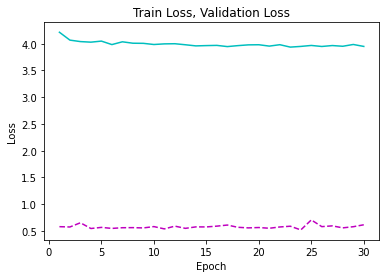

In [21]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'c-', label='train_loss')
plt.plot(epoch, val_loss, 'm--', label='val_loss')
plt.title('Train Loss, Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
model_2.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15 # 30.20.15 

history_2= model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 10s 33ms/step - loss: 0.6927 - accuracy: 0.5216 - val_loss: 0.6922 - val_accuracy: 0.5281
Epoch 2/15
227/227 [==============================] - 6s 28ms/step - loss: 0.6914 - accuracy: 0.5440 - val_loss: 0.6904 - val_accuracy: 0.5516
Epoch 3/15
227/227 [==============================] - 6s 28ms/step - loss: 0.6881 - accuracy: 0.5775 - val_loss: 0.6846 - val_accuracy: 0.6096
Epoch 4/15
227/227 [==============================] - 6s 28ms/step - loss: 0.6753 - accuracy: 0.6418 - val_loss: 0.6613 - val_accuracy: 0.6862
Epoch 5/15
227/227 [==============================] - 7s 29ms/step - loss: 0.6316 - accuracy: 0.6974 - val_loss: 0.5984 - val_accuracy: 0.7004
Epoch 6/15
227/227 [==============================] - 7s 29ms/step - loss: 0.5684 - accuracy: 0.7237 - val_loss: 0.5499 - val_accuracy: 0.7290
Epoch 7/15
227/227 [==============================] - 7s 29ms/step - loss: 0.5329 - accuracy: 0.7397 - val_loss: 0.5297 - val_accuracy: 0.731

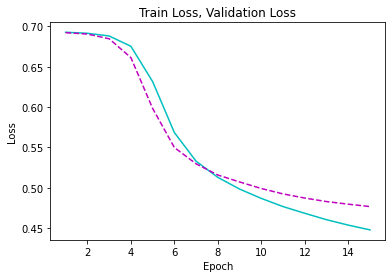

In [23]:
history_dict_2 = history_2.history

loss = history_dict_2['loss']
val_loss = history_dict_2['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'c-', label='train_loss')
plt.plot(epoch, val_loss, 'm--', label='val_loss')
plt.title('Train Loss, Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
model_3.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_3 = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
227/227 [==============================] - 2s 6ms/step - loss: 0.6894 - accuracy: 0.5713 - val_loss: 0.6864 - val_accuracy: 0.6615
Epoch 2/50
227/227 [==============================] - 1s 6ms/step - loss: 0.6836 - accuracy: 0.7121 - val_loss: 0.6810 - val_accuracy: 0.7432
Epoch 3/50
227/227 [==============================] - 1s 6ms/step - loss: 0.6779 - accuracy: 0.7653 - val_loss: 0.6752 - val_accuracy: 0.7733
Epoch 4/50
227/227 [==============================] - 1s 6ms/step - loss: 0.6717 - accuracy: 0.7867 - val_loss: 0.6685 - val_accuracy: 0.7774
Epoch 5/50
227/227 [==============================] - 1s 6ms/step - loss: 0.6644 - accuracy: 0.7909 - val_loss: 0.6613 - val_accuracy: 0.7869
Epoch 6/50
227/227 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.7980 - val_loss: 0.6537 - val_accuracy: 0.7944
Epoch 7/50
227/227 [==============================] - 1s 6ms/step - loss: 0.6489 - accuracy: 0.8040 - val_loss: 0.6457 - val_accuracy: 0.7986
Epoch 

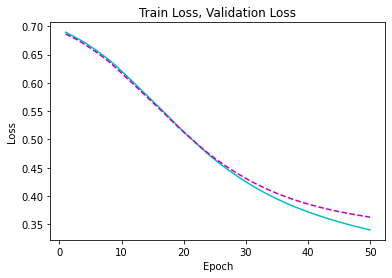

In [25]:
history_dict_3 = history_3.history

loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'c-', label='train_loss')
plt.plot(epoch, val_loss, 'm--', label='val_loss')
plt.title('Train Loss, Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

 
## 6) 학습된 Embedding 레이어 분석  (evaluate)


In [26]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6263 - accuracy: 0.6821
[0.6263409852981567, 0.6821205615997314]


In [27]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2)

print(results_2)

1537/1537 - 3s - loss: 0.4813 - accuracy: 0.7593
[0.4813055992126465, 0.7593221664428711]


In [28]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2)

print(results_3)

1537/1537 - 2s - loss: 0.3714 - accuracy: 0.8383
[0.37142953276634216, 0.8382936120033264]


처음 모델을 구성하고 학습 및 평가를 진행했을 때 85%가 넘는 정확도를 보이는 모델은 없었다.모델 3이 가장 높은 점수를 얻었다. 모델 3은 globalmaxpooling층만 있는 모델이었다. gensim을 통해 특정 단어와 유사하다고 판단되는 단어를 출력해보았다.

In [29]:
embedding_layer_2 = model_2.layers[0]
weights_2 = embedding_layer_2.get_weights()[0]
print(weights_2.shape)    # shape: (vocab_size, embedding_dim)

(16000, 200)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_2.txt'
f = open(word2vec_file_path_2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_2 = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_2[i, :])))))
f.close()

In [31]:

word_vectors_2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_2, binary=False)
vector_2 = word_vectors_2['별로']
vector_2

array([-6.13982640e-02, -3.40202600e-02, -4.73821610e-02, -6.52188659e-02,
       -2.35515623e-03, -1.69341955e-02, -3.05042453e-02,  2.55670194e-02,
       -3.96852270e-02,  1.52509054e-03, -1.18428115e-02, -5.44087924e-02,
        1.32953515e-02,  5.85134514e-02, -9.49156820e-04,  3.91502455e-02,
        3.12522687e-02,  4.60935943e-02,  5.85552247e-04,  1.23813441e-02,
       -8.92635493e-04, -2.08944548e-03,  2.08878983e-02,  5.19361394e-03,
       -2.79421620e-02, -4.61811945e-02, -3.61853167e-02,  1.28046675e-02,
        1.08445284e-03,  2.24078726e-02, -3.01453061e-02,  1.72138605e-02,
       -1.16019603e-02,  5.40792719e-02,  2.77775228e-02, -5.85844740e-03,
       -3.20719846e-04,  1.33600188e-02,  1.16966413e-02, -2.57026870e-02,
        3.65606621e-02,  4.33737598e-02, -2.24937275e-02,  1.53917866e-02,
        2.76215449e-02, -4.50903475e-02,  4.29371297e-02, -1.19685766e-03,
        6.27273992e-02,  1.80737544e-02, -5.99017330e-02, -7.00997040e-02,
        3.56091820e-02, -

In [32]:
word_vectors_2.similar_by_word("별로")

[('높', 0.39566025137901306),
 ('발연기', 0.37855908274650574),
 ('최악', 0.37607240676879883),
 ('그나마', 0.3758350908756256),
 ('아무리', 0.3596257269382477),
 ('똥', 0.35193678736686707),
 ('낭비', 0.3475199043750763),
 ('짜증', 0.34690916538238525),
 ('도대체', 0.33931639790534973),
 ('별루', 0.3325654864311218)]

In [33]:
word_vectors_2.similar_by_word("최고")

[('재미있', 0.4389622211456299),
 ('수작', 0.4326368272304535),
 ('여운', 0.42874875664711),
 ('잊혀', 0.42870163917541504),
 ('꼭', 0.41570204496383667),
 ('행복', 0.4118836224079132),
 ('재밌', 0.39811939001083374),
 ('낮', 0.39773109555244446),
 ('흥미진진', 0.39240872859954834),
 ('짱', 0.39112088084220886)]

그래도 제법 비슷한 단어들이 출력되는 걸 확인했지만 조금 모자라다고 느꼈다.

## 7) 한국어 Word2Vec 임베딩 활용하여 성능 개선  

미리 학습된 임베딩 벡터를 이용해 본다.  
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러온다.  
또한 모델을 활용할 때에는 .wv를 붙여서 활용한다.

In [40]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv
vector[0].shape

(100,)

In [41]:
word2vec.__dict__

{'max_final_vocab': None,
 'callbacks': (),
 'load': <function gensim.utils.call_on_class_only(*args, **kwargs)>,
 'wv': <gensim.models.keyedvectors.KeyedVectors at 0x7f8a4527ee80>,
 'sg': 0,
 'alpha': 0.025,
 'window': 5,
 'random': RandomState(MT19937) at 0x7F8A32242340,
 'min_alpha': 0.0001,
 'hs': 0,
 'negative': 5,
 'ns_exponent': 0.75,
 'cbow_mean': 1,
 'compute_loss': False,
 'running_training_loss': 0.0,
 'min_alpha_yet_reached': 0.00010015039165118741,
 'corpus_count': 6986957,
 'corpus_total_words': 211973807,
 'vector_size': 100,
 'workers': 4,
 'epochs': 5,
 'train_count': 1,
 'total_train_time': 696.1462697850002,
 'batch_words': 10000,
 'model_trimmed_post_training': False,
 '__numpys': [],
 '__scipys': [],
 '__ignoreds': [],
 '__recursive_saveloads': ['wv', 'vocabulary', 'trainables'],
 'cum_table': array([  22874462,   37066769,   50485921, ..., 2147482710, 2147483178,
        2147483647], dtype=uint32),
 'max_vocab_size': None,
 'min_count': 5,
 'sample': 0.001,
 'sort

In [42]:
vocab_size = 16000 # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100

In [43]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv :
        embedding_matrix[i] =word2vec.wv[index_to_word[i]]

In [45]:
# 모델 구성

model_4 = tf.keras.Sequential()

model_4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서_ 임베딩 매트릭스 셰이프 맞춰줄 것                                  input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_4.add(tf.keras.layers.MaxPooling1D(5))
model_4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_4.add(tf.keras.layers.GlobalMaxPooling1D())

model_4.add(tf.keras.layers.Dense(8, activation='relu'))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_4.summary() #sample 을 하나 넣지 않아도!(초기의 웨이트가 있으므로)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [48]:
model_4.compile(optimizer = 'rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
              
epochs=15 # 30.20.15 

history_4= model_4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 3s 7ms/step - loss: 0.6551 - accuracy: 0.6045 - val_loss: 0.5965 - val_accuracy: 0.6710
Epoch 2/15
227/227 [==============================] - 1s 6ms/step - loss: 0.5731 - accuracy: 0.6926 - val_loss: 0.5703 - val_accuracy: 0.6983
Epoch 3/15
227/227 [==============================] - 1s 6ms/step - loss: 0.5296 - accuracy: 0.7262 - val_loss: 0.5338 - val_accuracy: 0.7239
Epoch 4/15
227/227 [==============================] - 1s 6ms/step - loss: 0.4999 - accuracy: 0.7463 - val_loss: 0.5219 - val_accuracy: 0.7287
Epoch 5/15
227/227 [==============================] - 1s 6ms/step - loss: 0.4768 - accuracy: 0.7593 - val_loss: 0.4940 - val_accuracy: 0.7484
Epoch 6/15
227/227 [==============================] - 1s 6ms/step - loss: 0.4574 - accuracy: 0.7700 - val_loss: 0.4908 - val_accuracy: 0.7511
Epoch 7/15
227/227 [==============================] - 1s 6ms/step - loss: 0.4425 - accuracy: 0.7784 - val_loss: 0.4785 - val_accuracy: 0.7573
Epoch 

In [47]:
results_4 = model_4.evaluate(X_test,  y_test, verbose=2)

print(results_3)

1537/1537 - 3s - loss: 2.0149 - accuracy: 0.5027
[0.37142953276634216, 0.8382936120033264]


## Discussions

- 형태소 분석기 Mecab 말고 kkma 써보기  


- globalmaxpooling


- 시도: dim 조정, num_words 조정  
    모델 조정, 모델 하이퍼파라미터 조정  
    옵티마이저 lr 조정  
    토크나이저 변화 (메모리터짐)  
    에폭 15,30, 40  
    배치사이즈 512, 1024  

## References

ref.1 https://mr-doosun.tistory.com/24 (한국어 불용어 리스트 작성)  
ref.2 https://docs.python.org/3/library/collections.html (most_common 메서드)
